In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Activation, Input, Embedding, LSTM, Dense, Lambda, GaussianNoise, concatenate
from keras.models import Model
import numpy as np
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.constraints import max_norm
from keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Activation, Conv2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt


/Users/arhumsavera/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load the data

In [2]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert y_train and y_test to categorical binary values 
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [3]:
X_train.shape

(60000, 28, 28)

### Preprocessing the data

In [4]:
# Reshape them to batch_size, width,height,#channels
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the values
X_train /= 255
X_test /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


### Define the teacher model

In [5]:
# Teacher model

input_shape = (28, 28, 1) # Input shape of each image

# Hyperparameters
nb_filters = 64 # number of convolutional filters to use
pool_size = (2, 2) # size of pooling area for max pooling
kernel_size = (3, 3) # convolution kernel size

teacher = Sequential()
teacher.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
teacher.add(Conv2D(64, (3, 3), activation='relu'))
teacher.add(MaxPooling2D(pool_size=(2, 2)))

teacher.add(Dropout(0.25)) # For reguralization

teacher.add(Flatten())
teacher.add(Dense(128, activation='relu'))
teacher.add(Dropout(0.5)) # For reguralization

teacher.add(Dense(nb_classes))
teacher.add(Activation('softmax')) # Note that we add a normal softmax layer to begin with

teacher.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(teacher.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)      

### Define the student model

In [6]:
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model

student = Sequential()
student.add(Flatten(input_shape=input_shape))
student.add(Dense(32, activation='relu'))
student.add(Dropout(0.2))
student.add(Dense(nb_classes))
student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

student.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### Training the teacher model

In [7]:
# Train the teacher model as usual
epochs = 4
batch_size = 256
teacher.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 76s 1ms/step - loss: 0.3577 - acc: 0.8881 - val_loss: 0.0741 - val_acc: 0.9783
Epoch 2/4
60000/60000 [==============================] - 75s 1ms/step - loss: 0.1049 - acc: 0.9688 - val_loss: 0.0464 - val_acc: 0.9841
Epoch 3/4
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0771 - acc: 0.9772 - val_loss: 0.0383 - val_acc: 0.9869
Epoch 4/4
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0628 - acc: 0.9816 - val_loss: 0.0363 - val_acc: 0.9869


### Define a new model that outputs only teacher logits

In [8]:
for layer in teacher.layers:
    print(layer.name)

conv2d_1
conv2d_2
max_pooling2d_1
dropout_1
flatten_1
dense_1
dropout_2
dense_2
activation_1


In [9]:
# Raise the temperature of teacher model and gather the soft targets

# Set a tempature value
temp = 7

#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(teacher.input, teacher.get_layer('dense_2').output)


### Define a manual softmax function

In [10]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())


### Understanding the concept of temperature in softmax activation

[[4.0839434e-09 7.6483259e-10 8.8748038e-08 2.2979354e-07 5.6975698e-11
  1.0589407e-10 7.1403348e-12 9.9999791e-01 1.2292533e-08 1.7573556e-06]]


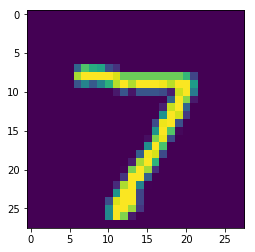

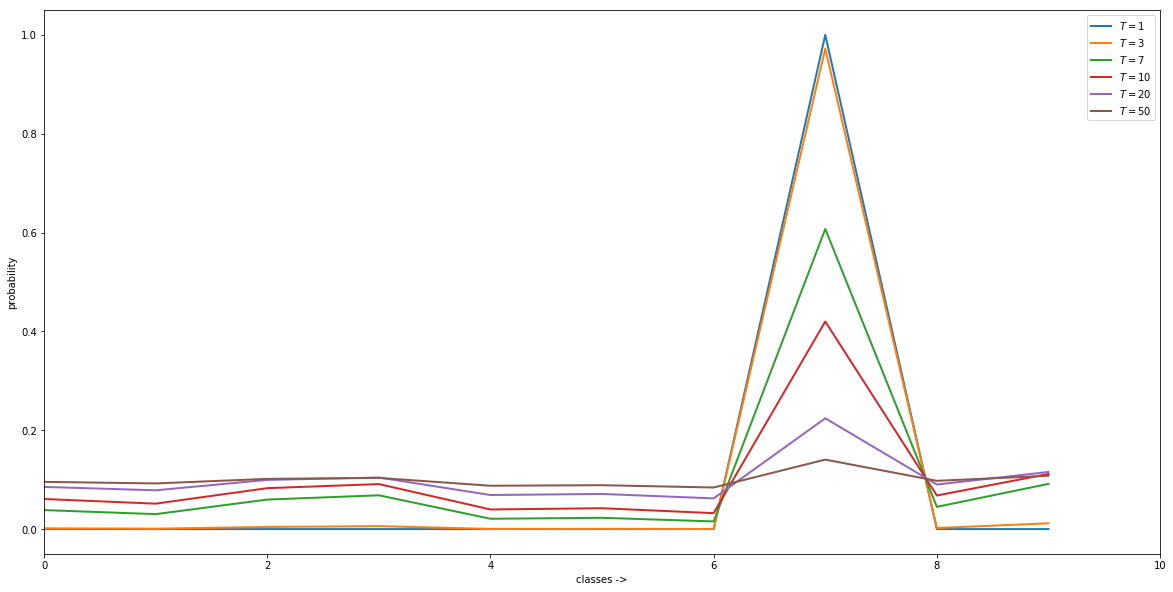

In [11]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(X_test[0].reshape(1,28,28,1))
print(softmax(intermediate_output))

pixels = X_test[0]
pixels = pixels.reshape((28, 28))
plt.imshow(pixels)
plt.show()

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize=(20, 10));

temperature = [1,3,7,10,20,50]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=2);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.show()

### Prepare the soft targets and the target data for student to be trained upon

In [12]:
teacher_train_logits = teacher_WO_Softmax.predict(X_train)
teacher_test_logits = teacher_WO_Softmax.predict(X_test) # This model directly gives the logits ( see the teacher_WO_softmax model above)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/temp
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate so that this becomes a 10 + 10 dimensional vector
Y_train_new = np.concatenate([Y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([Y_test, Y_test_soft], axis =1)

In [13]:
Y_train_new.shape

(60000, 20)

In [14]:
Y_test_new.shape

(10000, 20)

In [15]:
X_train.shape

(60000, 28, 28, 1)

In [16]:
Y_train_new[0]

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.4738492e-06, 1.5891392e-06,
       1.4573154e-06, 1.9540353e-06, 1.5284814e-06, 2.1048202e-06,
       1.5611621e-06, 1.6044302e-06, 1.6385542e-06, 1.7065946e-06],
      dtype=float32)

### Prepare the student model that outputs probabilities with and without temperature

In [17]:
# Remove the softmax layer from the student network
student.layers.pop()

# Now collect the logits from the last layer
logits = student.layers[-1].output # This is going to be a tensor. And hence it needs to pass through a Activation layer
probs = Activation('softmax')(logits)

# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
student = Model(student.input, output)

student.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
flatten_2_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           flatten_2_input[0][0]            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           25120       flatten_2[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 32)           0           dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

### Declare knowledge distillation loss function

In [18]:
# This will be a teacher trained student model. 
# --> This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

student.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] )
    


### Train the student model

In [30]:
student.fit(X_train, Y_train_new,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(X_test, Y_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 9us/step - loss: 0.1552 - acc: 0.9183 - val_loss: 0.1531 - val_acc: 0.9387
Epoch 2/5
60000/60000 [==============================] - 1s 10us/step - loss: 0.1551 - acc: 0.9201 - val_loss: 0.1530 - val_acc: 0.9392
Epoch 3/5
60000/60000 [==============================] - 1s 9us/step - loss: 0.1551 - acc: 0.9196 - val_loss: 0.1530 - val_acc: 0.9392
Epoch 4/5
60000/60000 [==============================] - 1s 9us/step - loss: 0.1550 - acc: 0.9209 - val_loss: 0.1529 - val_acc: 0.9402
Epoch 5/5
60000/60000 [==============================] - 1s 9us/step - loss: 0.1548 - acc: 0.9219 - val_loss: 0.1529 - val_acc: 0.9397


In [20]:
# This is a standalone student model (same number of layers as original student model) trained on same data
# for comparing it with teacher trained student.

n_student = Sequential()
n_student.add(Flatten(input_shape=input_shape))
n_student.add(Dense(32, activation='relu'))
n_student.add(Dropout(0.2))
n_student.add(Dense(nb_classes))
n_student.add(Activation('softmax'))

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
n_student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


In [21]:
n_student.fit(X_train, Y_train,
          batch_size=256,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 1s 13us/step - loss: 0.7226 - acc: 0.7881 - val_loss: 0.3277 - val_acc: 0.9084
Epoch 2/4
60000/60000 [==============================] - 0s 8us/step - loss: 0.3835 - acc: 0.8880 - val_loss: 0.2564 - val_acc: 0.9251
Epoch 3/4
60000/60000 [==============================] - 0s 7us/step - loss: 0.3188 - acc: 0.9070 - val_loss: 0.2150 - val_acc: 0.9382
Epoch 4/4
60000/60000 [==============================] - 0s 8us/step - loss: 0.2877 - acc: 0.9160 - val_loss: 0.1985 - val_acc: 0.9428


In [22]:
n_student.evaluate(X_test, Y_test)

10000/10000 [==============================] - 0s 12us/step


[0.19853909218907356, 0.9428]

In [23]:
n_student.metrics_names

['loss', 'acc']

In [24]:
preds = student.predict(X_test)[: , :nb_classes]

In [25]:
from sklearn.metrics import accuracy_score